### Connect to Drive

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/Progetto AN2DL/4_HyperparametersTesting

Mounted at /gdrive
/gdrive/My Drive/Progetto AN2DL/4_HyperparametersTesting


### Import libraries

In [2]:
# Hide warnings
import os

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np

import logging

In [3]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
print(tf.__version__)

2.14.0


In [4]:
# Import other libraries
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
import pickle

### Load and process the dataset

In [5]:
# Load data
data = np.load('../clean_data.npz', allow_pickle=True)

# Save labels in a new list (image pixel values are float in [0, 1])
images = data['data']

# Save labels in a new list
labels = data['labels']

# Print data shape
print(images.shape, labels.shape)

(5004, 96, 96, 3) (5004,)


In [6]:
# Convert labels from string to integer
num_labels = []
for label in labels:
  if label == "healthy":
    num_labels.append(0)
  else:
    num_labels.append(1)

# Convert labels in the one-hot encoding format
num_labels = np.array(num_labels)
labels = tfk.utils.to_categorical(num_labels, 2)

# Split data into train and val sets
X_train, X_val, y_train, y_val = train_test_split(
    images,
    labels,
    test_size=0.1,
    stratify=labels
)

# Print shapes of the datasets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")

X_train shape: (4503, 96, 96, 3), y_train shape: (4503, 2)
X_val shape: (501, 96, 96, 3), y_val shape: (501, 2)


### ConvNeXtLarge + Dropout Model

In [7]:
# Import Feature Extractor with specified settings
feature_extractor = tfk.applications.ConvNeXtLarge(
    input_shape=(96, 96, 3),
    include_top=False,
    weights="imagenet",
    pooling='avg',
    include_preprocessing=True,
)

785596384/785596384 [==============================] - 30s 0us/step


In [8]:
# Define network parameters/callbacks
learning_rate = 1e-3

lr_scheduler = tfk.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=5,
    factor=0.999,
    mode='max',
    min_lr=1e-5
)

early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=20,
    restore_best_weights=True
)

In [10]:
def build_model(feature_extractor, dropout_rate, learning_rate=0.001):
  # Use the supernet as feature extractor, i.e. freeze all its weigths
  feature_extractor.trainable = False

  # Create an input layer with shape (96, 96, 3)
  inputs = tfk.Input(shape=(96, 96, 3), name='Input')

  # Connect FeatureExtractor to the input
  x = feature_extractor(inputs)

  # Hidden layers
  x = tfkl.Dense(units=256, name='HiddenDense1')(x)
  x = tfkl.Activation('relu', name='HiddenActivation1')(x)
  dropout = tfkl.Dropout(dropout_rate)(x)
  x = tfkl.Dense(units=256, name='HiddenDense2')(dropout)
  x = tfkl.Activation('relu', name='HiddenActivation2')(x)
  dropout = tfkl.Dropout(dropout_rate)(x)

  # Add a Dense layer with 2 unit and softmax activation as the classifier
  outputs = tfkl.Dense(2, activation='softmax')(dropout)

  # Create a Model connecting input and output
  model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

  # Compile the model with Categorical Cross-Entropy loss and Adam optimizer
  model.compile(loss=tfk.losses.CategoricalCrossentropy(),
                optimizer=tfk.optimizers.Adam(learning_rate),
                metrics=['accuracy'])

  # Return the model
  return model

### Dropout Rate = 1/15

In [11]:
dropout_rate = 1/15

model1 = build_model(feature_extractor, dropout_rate, learning_rate)
model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 convnext_large (Functional  (None, 1536)              196230336 
 )                                                               
                                                                 
 HiddenDense1 (Dense)        (None, 256)               393472    
                                                                 
 HiddenActivation1 (Activat  (None, 256)               0         
 ion)                                                            
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 HiddenDense2 (Dense)        (None, 256)               65792 

In [12]:
# Train the model
history1 = model1.fit(
    x = X_train*255,
    y = y_train,
    batch_size = 16,
    epochs = 200,
    validation_data = (X_val*255, y_val),
    callbacks = [early_stopping, lr_scheduler]
).history

Epoch 1/200
282/282 [==============================] - 75s 169ms/step - loss: 0.4771 - accuracy: 0.7826 - val_loss: 0.3410 - val_accuracy: 0.8563 - lr: 0.0010
Epoch 2/200
282/282 [==============================] - 35s 124ms/step - loss: 0.3195 - accuracy: 0.8559 - val_loss: 0.3681 - val_accuracy: 0.8403 - lr: 0.0010
Epoch 3/200
282/282 [==============================] - 35s 126ms/step - loss: 0.2739 - accuracy: 0.8807 - val_loss: 0.3158 - val_accuracy: 0.8743 - lr: 0.0010
Epoch 4/200
282/282 [==============================] - 35s 125ms/step - loss: 0.2458 - accuracy: 0.8978 - val_loss: 0.2973 - val_accuracy: 0.8782 - lr: 0.0010
Epoch 5/200
282/282 [==============================] - 36s 127ms/step - loss: 0.2194 - accuracy: 0.9096 - val_loss: 0.2956 - val_accuracy: 0.8842 - lr: 0.0010
Epoch 6/200
282/282 [==============================] - 35s 124ms/step - loss: 0.1966 - accuracy: 0.9154 - val_loss: 0.3729 - val_accuracy: 0.8563 - lr: 0.0010
Epoch 7/200
282/282 [=========================

In [13]:
# Save the model
model1.save('Dropout_1_15')
with open('Dropout_1_15/history.pkl', 'wb') as f:
  pickle.dump(history1, f)

### Dropout Rate = 1/12

In [14]:
dropout_rate = 1/12

model2 = build_model(feature_extractor, dropout_rate, learning_rate)
model2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 convnext_large (Functional  (None, 1536)              196230336 
 )                                                               
                                                                 
 HiddenDense1 (Dense)        (None, 256)               393472    
                                                                 
 HiddenActivation1 (Activat  (None, 256)               0         
 ion)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 HiddenDense2 (Dense)        (None, 256)               65792 

In [15]:
# Train the model
history2 = model2.fit(
    x = X_train*255,
    y = y_train,
    batch_size = 16,
    epochs = 200,
    validation_data = (X_val*255, y_val),
    callbacks = [early_stopping, lr_scheduler]
).history

Epoch 1/200
282/282 [==============================] - 55s 139ms/step - loss: 0.4666 - accuracy: 0.7908 - val_loss: 0.3948 - val_accuracy: 0.8383 - lr: 0.0010
Epoch 2/200
282/282 [==============================] - 35s 125ms/step - loss: 0.3200 - accuracy: 0.8612 - val_loss: 0.3183 - val_accuracy: 0.8543 - lr: 0.0010
Epoch 3/200
282/282 [==============================] - 35s 124ms/step - loss: 0.2855 - accuracy: 0.8796 - val_loss: 0.3051 - val_accuracy: 0.8743 - lr: 0.0010
Epoch 4/200
282/282 [==============================] - 35s 123ms/step - loss: 0.2509 - accuracy: 0.8965 - val_loss: 0.3455 - val_accuracy: 0.8423 - lr: 0.0010
Epoch 5/200
282/282 [==============================] - 34s 122ms/step - loss: 0.2222 - accuracy: 0.9054 - val_loss: 0.2920 - val_accuracy: 0.8703 - lr: 0.0010
Epoch 6/200
282/282 [==============================] - 35s 123ms/step - loss: 0.2061 - accuracy: 0.9149 - val_loss: 0.2945 - val_accuracy: 0.8703 - lr: 0.0010
Epoch 7/200
282/282 [=========================

In [16]:
# Save the model
model2.save('Dropout_1_12')
with open('Dropout_1_12/history.pkl', 'wb') as f:
  pickle.dump(history2, f)

### Dropout Rate = 1/10

In [17]:
dropout_rate = 1/10

model3 = build_model(feature_extractor, dropout_rate, learning_rate)
model3.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 convnext_large (Functional  (None, 1536)              196230336 
 )                                                               
                                                                 
 HiddenDense1 (Dense)        (None, 256)               393472    
                                                                 
 HiddenActivation1 (Activat  (None, 256)               0         
 ion)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 HiddenDense2 (Dense)        (None, 256)               65792 

In [18]:
# Train the model
history3 = model3.fit(
    x = X_train*255,
    y = y_train,
    batch_size = 16,
    epochs = 200,
    validation_data = (X_val*255, y_val),
    callbacks = [early_stopping, lr_scheduler]
).history

Epoch 1/200
282/282 [==============================] - 54s 138ms/step - loss: 0.4802 - accuracy: 0.7828 - val_loss: 0.3950 - val_accuracy: 0.8024 - lr: 0.0010
Epoch 2/200
282/282 [==============================] - 35s 124ms/step - loss: 0.3530 - accuracy: 0.8454 - val_loss: 0.3467 - val_accuracy: 0.8423 - lr: 0.0010
Epoch 3/200
282/282 [==============================] - 35s 124ms/step - loss: 0.2949 - accuracy: 0.8728 - val_loss: 0.3342 - val_accuracy: 0.8523 - lr: 0.0010
Epoch 4/200
282/282 [==============================] - 35s 124ms/step - loss: 0.2487 - accuracy: 0.8972 - val_loss: 0.3041 - val_accuracy: 0.8743 - lr: 0.0010
Epoch 5/200
282/282 [==============================] - 35s 124ms/step - loss: 0.2290 - accuracy: 0.9045 - val_loss: 0.2995 - val_accuracy: 0.8762 - lr: 0.0010
Epoch 6/200
282/282 [==============================] - 34s 122ms/step - loss: 0.2021 - accuracy: 0.9174 - val_loss: 0.3019 - val_accuracy: 0.8683 - lr: 0.0010
Epoch 7/200
282/282 [=========================

In [19]:
# Save the model
model3.save('Dropout_1_10')
with open('Dropout_1_10/history.pkl', 'wb') as f:
  pickle.dump(history3, f)

### Dropout Rate = 1/8

In [20]:
dropout_rate = 1/8

model4 = build_model(feature_extractor, dropout_rate, learning_rate)
model4.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 convnext_large (Functional  (None, 1536)              196230336 
 )                                                               
                                                                 
 HiddenDense1 (Dense)        (None, 256)               393472    
                                                                 
 HiddenActivation1 (Activat  (None, 256)               0         
 ion)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 HiddenDense2 (Dense)        (None, 256)               65792 

In [21]:
# Train the model
history4 = model4.fit(
    x = X_train*255,
    y = y_train,
    batch_size = 16,
    epochs = 200,
    validation_data = (X_val*255, y_val),
    callbacks = [early_stopping, lr_scheduler]
).history

Epoch 1/200
282/282 [==============================] - 53s 138ms/step - loss: 0.4836 - accuracy: 0.7781 - val_loss: 0.4508 - val_accuracy: 0.7984 - lr: 0.0010
Epoch 2/200
282/282 [==============================] - 35s 124ms/step - loss: 0.3294 - accuracy: 0.8534 - val_loss: 0.4272 - val_accuracy: 0.8044 - lr: 0.0010
Epoch 3/200
282/282 [==============================] - 35s 124ms/step - loss: 0.2923 - accuracy: 0.8734 - val_loss: 0.3180 - val_accuracy: 0.8643 - lr: 0.0010
Epoch 4/200
282/282 [==============================] - 35s 124ms/step - loss: 0.2535 - accuracy: 0.8885 - val_loss: 0.3902 - val_accuracy: 0.8663 - lr: 0.0010
Epoch 5/200
282/282 [==============================] - 35s 122ms/step - loss: 0.2332 - accuracy: 0.9058 - val_loss: 0.3062 - val_accuracy: 0.8643 - lr: 0.0010
Epoch 6/200
282/282 [==============================] - 35s 122ms/step - loss: 0.2034 - accuracy: 0.9154 - val_loss: 0.3402 - val_accuracy: 0.8663 - lr: 0.0010
Epoch 7/200
282/282 [=========================

In [22]:
# Save the model
model4.save('Dropout_1_8')
with open('Dropout_1_8/history.pkl', 'wb') as f:
  pickle.dump(history4, f)

### Dropout Rate = 1/6

In [23]:
dropout_rate = 1/6

model5 = build_model(feature_extractor, dropout_rate, learning_rate)
model5.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 convnext_large (Functional  (None, 1536)              196230336 
 )                                                               
                                                                 
 HiddenDense1 (Dense)        (None, 256)               393472    
                                                                 
 HiddenActivation1 (Activat  (None, 256)               0         
 ion)                                                            
                                                                 
 dropout_8 (Dropout)         (None, 256)               0         
                                                                 
 HiddenDense2 (Dense)        (None, 256)               65792 

In [24]:
# Train the model
history5 = model5.fit(
    x = X_train*255,
    y = y_train,
    batch_size = 16,
    epochs = 200,
    validation_data = (X_val*255, y_val),
    callbacks = [early_stopping, lr_scheduler]
).history

Epoch 1/200
282/282 [==============================] - 54s 139ms/step - loss: 0.4942 - accuracy: 0.7622 - val_loss: 0.3911 - val_accuracy: 0.8204 - lr: 0.0010
Epoch 2/200
282/282 [==============================] - 35s 124ms/step - loss: 0.3582 - accuracy: 0.8410 - val_loss: 0.3247 - val_accuracy: 0.8683 - lr: 0.0010
Epoch 3/200
282/282 [==============================] - 34s 122ms/step - loss: 0.2928 - accuracy: 0.8774 - val_loss: 0.3749 - val_accuracy: 0.8443 - lr: 0.0010
Epoch 4/200
282/282 [==============================] - 35s 125ms/step - loss: 0.2700 - accuracy: 0.8847 - val_loss: 0.2942 - val_accuracy: 0.8782 - lr: 0.0010
Epoch 5/200
282/282 [==============================] - 34s 122ms/step - loss: 0.2530 - accuracy: 0.8914 - val_loss: 0.3538 - val_accuracy: 0.8523 - lr: 0.0010
Epoch 6/200
282/282 [==============================] - 35s 124ms/step - loss: 0.2180 - accuracy: 0.9132 - val_loss: 0.3278 - val_accuracy: 0.8842 - lr: 0.0010
Epoch 7/200
282/282 [=========================

In [25]:
# Save the model
model5.save('Dropout_1_6')
with open('Dropout_1_6/history.pkl', 'wb') as f:
  pickle.dump(history5, f)

### Dropout Rate = 1/4

In [26]:
dropout_rate = 1/4

model6 = build_model(feature_extractor, dropout_rate, learning_rate)
model6.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 convnext_large (Functional  (None, 1536)              196230336 
 )                                                               
                                                                 
 HiddenDense1 (Dense)        (None, 256)               393472    
                                                                 
 HiddenActivation1 (Activat  (None, 256)               0         
 ion)                                                            
                                                                 
 dropout_10 (Dropout)        (None, 256)               0         
                                                                 
 HiddenDense2 (Dense)        (None, 256)               65792 

In [27]:
# Train the model
history6 = model6.fit(
    x = X_train*255,
    y = y_train,
    batch_size = 16,
    epochs = 200,
    validation_data = (X_val*255, y_val),
    callbacks = [early_stopping, lr_scheduler]
).history

Epoch 1/200
282/282 [==============================] - 54s 138ms/step - loss: 0.5321 - accuracy: 0.7555 - val_loss: 0.3612 - val_accuracy: 0.8323 - lr: 0.0010
Epoch 2/200
282/282 [==============================] - 35s 124ms/step - loss: 0.3703 - accuracy: 0.8374 - val_loss: 0.3351 - val_accuracy: 0.8563 - lr: 0.0010
Epoch 3/200
282/282 [==============================] - 35s 123ms/step - loss: 0.3270 - accuracy: 0.8517 - val_loss: 0.3193 - val_accuracy: 0.8842 - lr: 0.0010
Epoch 4/200
282/282 [==============================] - 34s 122ms/step - loss: 0.2935 - accuracy: 0.8790 - val_loss: 0.3663 - val_accuracy: 0.8583 - lr: 0.0010
Epoch 5/200
282/282 [==============================] - 34s 122ms/step - loss: 0.2598 - accuracy: 0.8887 - val_loss: 0.3444 - val_accuracy: 0.8643 - lr: 0.0010
Epoch 6/200
282/282 [==============================] - 34s 122ms/step - loss: 0.2402 - accuracy: 0.9027 - val_loss: 0.3017 - val_accuracy: 0.8683 - lr: 0.0010
Epoch 7/200
282/282 [=========================

In [28]:
# Save the model
model6.save('Dropout_1_4')
with open('Dropout_1_4/history.pkl', 'wb') as f:
  pickle.dump(history6, f)

### No Dropout

In [29]:
def build_model(feature_extractor, learning_rate=0.001):
  # Use the supernet as feature extractor, i.e. freeze all its weigths
  feature_extractor.trainable = False

  # Create an input layer with shape (96, 96, 3)
  inputs = tfk.Input(shape=(96, 96, 3), name='Input')

  # Connect FeatureExtractor to the input
  x = feature_extractor(inputs)

  # Hidden layers
  x = tfkl.Dense(units=256, name='HiddenDense1')(x)
  x = tfkl.Activation('relu', name='HiddenActivation1')(x)
  x = tfkl.Dense(units=256, name='HiddenDense2')(x)
  x = tfkl.Activation('relu', name='HiddenActivation2')(x)

  # Add a Dense layer with 2 unit and softmax activation as the classifier
  outputs = tfkl.Dense(2, activation='softmax')(x)

  # Create a Model connecting input and output
  model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

  # Compile the model with Categorical Cross-Entropy loss and Adam optimizer
  model.compile(loss=tfk.losses.CategoricalCrossentropy(),
                optimizer=tfk.optimizers.Adam(learning_rate),
                metrics=['accuracy'])

  # Return the model
  return model

In [30]:
model7 = build_model(feature_extractor, learning_rate)
model7.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 convnext_large (Functional  (None, 1536)              196230336 
 )                                                               
                                                                 
 HiddenDense1 (Dense)        (None, 256)               393472    
                                                                 
 HiddenActivation1 (Activat  (None, 256)               0         
 ion)                                                            
                                                                 
 HiddenDense2 (Dense)        (None, 256)               65792     
                                                                 
 HiddenActivation2 (Activat  (None, 256)               0     

In [31]:
# Train the model
history7 = model7.fit(
    x = X_train*255,
    y = y_train,
    batch_size = 16,
    epochs = 200,
    validation_data = (X_val*255, y_val),
    callbacks = [early_stopping, lr_scheduler]
).history

Epoch 1/200
282/282 [==============================] - 53s 138ms/step - loss: 0.4306 - accuracy: 0.8046 - val_loss: 0.3743 - val_accuracy: 0.8623 - lr: 0.0010
Epoch 2/200
282/282 [==============================] - 34s 122ms/step - loss: 0.3195 - accuracy: 0.8621 - val_loss: 0.3192 - val_accuracy: 0.8623 - lr: 0.0010
Epoch 3/200
282/282 [==============================] - 35s 123ms/step - loss: 0.2593 - accuracy: 0.8932 - val_loss: 0.2679 - val_accuracy: 0.8942 - lr: 0.0010
Epoch 4/200
282/282 [==============================] - 34s 122ms/step - loss: 0.2266 - accuracy: 0.9038 - val_loss: 0.2987 - val_accuracy: 0.8683 - lr: 0.0010
Epoch 5/200
282/282 [==============================] - 34s 122ms/step - loss: 0.1993 - accuracy: 0.9158 - val_loss: 0.3692 - val_accuracy: 0.8723 - lr: 0.0010
Epoch 6/200
282/282 [==============================] - 34s 122ms/step - loss: 0.1662 - accuracy: 0.9316 - val_loss: 0.3866 - val_accuracy: 0.8543 - lr: 0.0010
Epoch 7/200
282/282 [=========================

In [32]:
# Save the model
model7.save('NoDropout')
with open('NoDropout/history.pkl', 'wb') as f:
  pickle.dump(history7, f)

### Plot

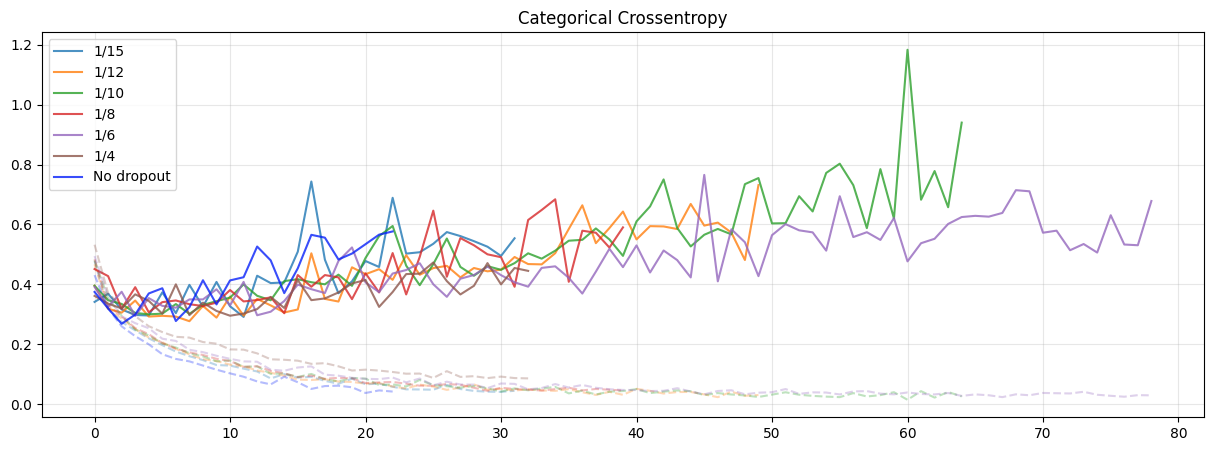

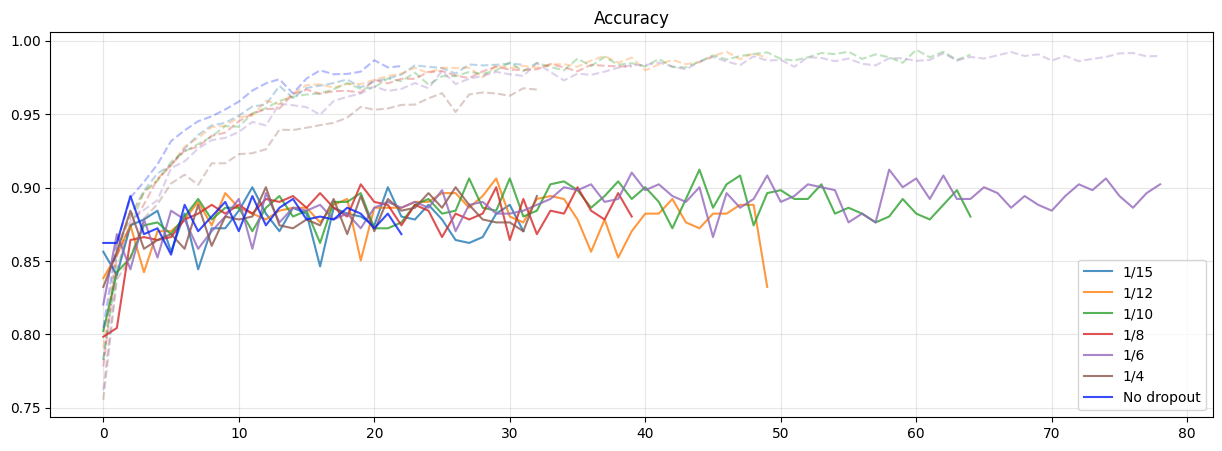

In [33]:
# Plot the training histories
plt.figure(figsize=(15,5))
plt.plot(history1['loss'], alpha=.3, color='#1f77b4', linestyle='--')
plt.plot(history1['val_loss'], label='1/15', alpha=.8, color='#1f77b4')
plt.plot(history2['loss'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history2['val_loss'], label='1/12', alpha=.8, color='#ff7f0e')
plt.plot(history3['loss'], alpha=.3, color='#2ca02c', linestyle='--')
plt.plot(history3['val_loss'], label='1/10', alpha=.8, color='#2ca02c')
plt.plot(history4['loss'], alpha=.3, color='#d62728', linestyle='--')
plt.plot(history4['val_loss'], label='1/8', alpha=.8, color='#d62728')
plt.plot(history5['loss'], alpha=.3, color='#9467bd', linestyle='--')
plt.plot(history5['val_loss'], label='1/6', alpha=.8, color='#9467bd')
plt.plot(history6['loss'], alpha=.3, color='#8c564b', linestyle='--')
plt.plot(history6['val_loss'], label='1/4', alpha=.8, color='#8c564b')
plt.plot(history7['loss'], alpha=.3, color='#0721f9', linestyle='--')
plt.plot(history7['val_loss'], label='No dropout', alpha=.8, color='#0721f9')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history1['accuracy'], alpha=.3, color='#1f77b4', linestyle='--')
plt.plot(history1['val_accuracy'], label='1/15', alpha=.8, color='#1f77b4')
plt.plot(history2['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history2['val_accuracy'], label='1/12', alpha=.8, color='#ff7f0e')
plt.plot(history3['accuracy'], alpha=.3, color='#2ca02c', linestyle='--')
plt.plot(history3['val_accuracy'], label='1/10', alpha=.8, color='#2ca02c')
plt.plot(history4['accuracy'], alpha=.3, color='#d62728', linestyle='--')
plt.plot(history4['val_accuracy'], label='1/8', alpha=.8, color='#d62728')
plt.plot(history5['accuracy'], alpha=.3, color='#9467bd', linestyle='--')
plt.plot(history5['val_accuracy'], label='1/6', alpha=.8, color='#9467bd')
plt.plot(history6['accuracy'], alpha=.3, color='#8c564b', linestyle='--')
plt.plot(history6['val_accuracy'], label='1/4', alpha=.8, color='#8c564b')
plt.plot(history7['accuracy'], alpha=.3, color='#0721f9', linestyle='--')
plt.plot(history7['val_accuracy'], label='No dropout', alpha=.8, color='#0721f9')
plt.legend(loc='lower right')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()